In [1]:
import pandas as pd
import numpy as np
def get_data(p):
    df = pd.read_csv('../%s.csv' % p)
    df = df[df[p] != '>400']
    df.atom_list = df.atom_list.apply(lambda x: list(map(int, x.split(','))))
    atom_dict = {
        12: 'Mg',
        13: 'Al',
        20: 'Ca',
        22: 'Ti',
        23: 'V',
        24: 'Cr',
        25: 'Mn',
        26: 'Fe',
        27: 'Co',
        28: 'Ni',
        29: 'Cu',
        30: 'Zn',
        38: 'Sr',
        56: 'Ba',
    }
    for an, name in atom_dict.items():
        df[name] = df.atom_list.apply(lambda x: x.count(an) / len(x))
    df_train = df[df.remark=='KS']
    df_test = df[~(df.remark=='KS')]
    X_train = df_train[atom_dict.values()]
    y_train = df_train[p]
    X_test = df_test[atom_dict.values()]
    y_test = df_test[p]
    X = df[atom_dict.values()]
    y = df[p]
    return df, X, y

# XGBoost

# T20

In [2]:
import xgboost
df, X, y = get_data('T20')
model = xgboost.XGBRegressor().fit(X, y)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


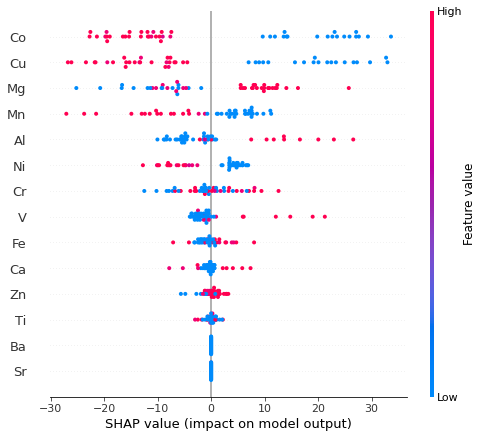

In [3]:
import shap
def shap_ana(clf, X, y):
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X)
    return explainer, shap_values
explainer, shap_values = shap_ana(model, X, y)

# T50

In [12]:
df, X, y = get_data('T50')
model = xgboost.XGBRegressor().fit(X, y)

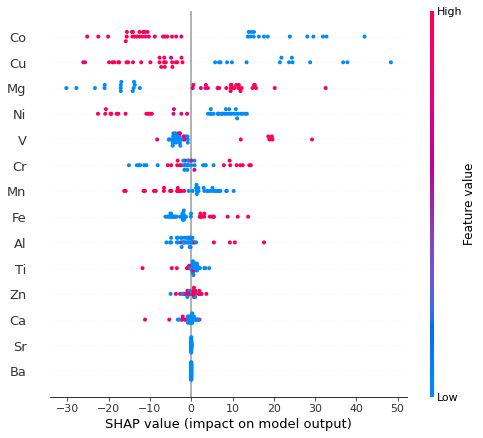

In [13]:
explainer, shap_values = shap_ana(model, X, y)

# T90

In [4]:
df, X, y = get_data('T90')
model = xgboost.XGBRegressor().fit(X, y)

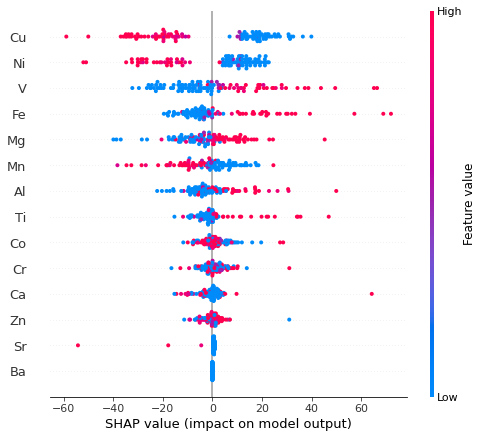

In [5]:
explainer, shap_values = shap_ana(model, X, y)

# T20_S

In [16]:
df, X, y = get_data('T20_S')
model = xgboost.XGBRegressor().fit(X, y)

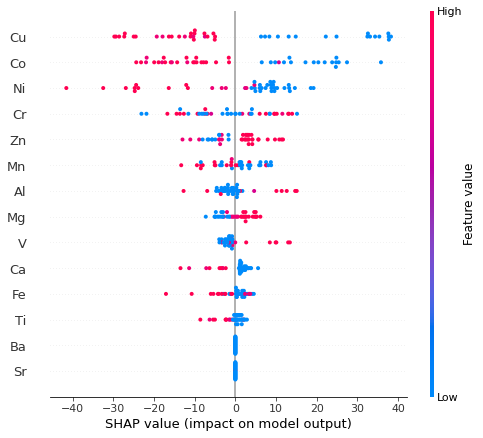

In [17]:
explainer, shap_values = shap_ana(model, X, y)

# T50_S

In [18]:
df, X, y = get_data('T50_S')
model = xgboost.XGBRegressor().fit(X, y)

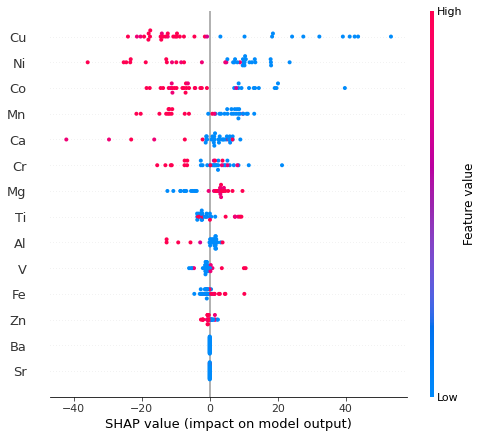

In [19]:
explainer, shap_values = shap_ana(model, X, y)

# T90_S

In [25]:
df, X, y = get_data('T90_S')
model = xgboost.XGBRegressor().fit(X, y)

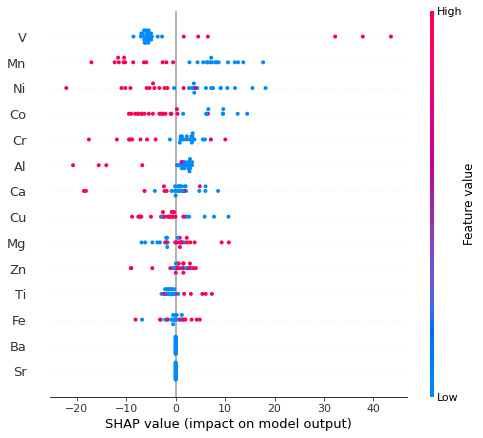

In [26]:
explainer, shap_values = shap_ana(model, X, y)

# Bayesian Optimization Search

In [55]:
from hyperopt import fmin, hp, tpe
def objective(params):
    s = sum(params.values())
    df_ = pd.DataFrame({})
    for an, c in params.items():
        df_[an] = [c / s]
    x = df_[atom_dict.values()]
    y = model.predict(x)
    return y[0]
    
SPACE = dict()
for an in atom_dict.values():
    SPACE[an] = hp.quniform(an, low=0, high=5, q=1)
fmin(objective, SPACE, algo=tpe.suggest, max_evals=200,
     rstate=np.random.RandomState(1))

100%|██████████| 200/200 [00:11<00:00, 17.01trial/s, best loss: 289.5696716308594] 


{'Al': 1.0,
 'Ba': 2.0,
 'Ca': 4.0,
 'Co': 1.0,
 'Cr': 0.0,
 'Cu': 5.0,
 'Fe': 1.0,
 'Mg': 0.0,
 'Mn': 3.0,
 'Ni': 3.0,
 'Sr': 3.0,
 'Ti': 0.0,
 'V': 2.0,
 'Zn': 5.0}

In [89]:
atom_dict = {
    12: 'Mg',
    13: 'Al',
    20: 'Ca',
    22: 'Ti',
    23: 'V',
    24: 'Cr',
    25: 'Mn',
    26: 'Fe',
    27: 'Co',
    28: 'Ni',
    29: 'Cu',
    30: 'Zn',
    38: 'Sr',
    56: 'Ba',
}
c = [5, 0, 5, 0, 0, 0, 0, 0, 5, 5, 5, 5, 0, 0]
#c = [0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0]
s = sum(c)
df_ = pd.DataFrame({})
for i, an in enumerate(atom_dict.values()):
    df_[an] = [c[i] / s]
x = df_[atom_dict.values()]
model.predict(x)

array([259.00058], dtype=float32)

In [56]:
atom_dict.values()

dict_values(['Mg', 'Al', 'Ca', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Sr', 'Ba'])

In [34]:
atom_dict.values()

dict_values(['Mg', 'Al', 'Ca', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Sr', 'Ba'])